# RQ4: Does sentiment disagreement in window $t$ predict price instability in window $t+1$ 

## Import functions and libraries
- Helper function that is defined to load the data safely with predefined schema.
- Import needed libraries
- Helper function to apply a common style to all the plots

In [ ]:
import sys

# Get the path to the helper functions
sys.path.append('../src/')

import importlib
import helper.data as data

# Reload helper functions
importlib.reload(data)

import polars as pl
import math
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import seaborn as sns


def apply_common_style(title: str, xlabel: str = "Date", ylabel: str = ""):
    # General Style for Matplotlib
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.tight_layout()
    plt.show()

## Load Twitter and Reddit datasets and Exploratory Data Analysis
Load the pre-concatinated datasets for reddit and twitter that contain data from part 1 to part 4 for the training.

In [ ]:
df_tweets = data.load_data_sentiment("../data/tweets_training.csv")
df_reddit = data.load_data_sentiment("../data/reddit_training.csv")

#### Prepare data
To prepare the data, we need to fix the datetime to data, and drop all unnecessary columns.

In [ ]:
def prepare(df: pl.DataFrame):
    return (
        df.select(["timestamp", "sentiment_score"])
             .drop_nulls("sentiment_score")
             .with_columns(
                 pl.col("timestamp").dt.date().alias("date"),
                 pl.col("sentiment_score").alias("score"),
         )
    )

#### Exploratory Data Analysis on the sentiment for Twitter and Reddit
We can make some plots to show the raw sentiment data for both Twitter and Reddit as EDA:
- Basic stats
- Sentiment score distribution in KDE plot
- Daily Sentiment Mean in time series
- Sentiment score distirbution in box plot
- Relationship between Twitter and Reddit using scatter plot

In [57]:
def print_basic_stats(df_tweets, df_reddit):
    tw = prepare(df_tweets)
    rd = prepare(df_reddit)

    stats = pd.DataFrame({
        "Twitter": tw["score"].to_pandas().describe(),
        "Reddit": rd["score"].to_pandas().describe()
    })

    print("\n===== BASIC SENTIMENT STATISTICS =====\n")
    print(stats)
    print("\nDifference in means:", stats.loc["mean", "Twitter"] - stats.loc["mean", "Reddit"])

    tw_pd = tw.group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    rd_pd = rd.group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    
    # Merge dates for correlation
    merged = tw_pd.merge(rd_pd, on="date", suffixes=("_twitter", "_reddit"))
    
    corr = merged["mean_twitter"].corr(merged["mean_reddit"])
    print("\n===== DAILY CORRELATION =====")
    print(f"Correlation between Twitter and Reddit daily sentiment: {corr:.4f}")
print_basic_stats(df_tweets, df_reddit)


===== BASIC SENTIMENT STATISTICS =====

            Twitter         Reddit
count  1.029673e+06  694769.000000
mean   1.200417e-01      -0.140882
std    3.736773e-01       0.487843
min   -9.589081e-01      -0.958790
25%    6.103516e-04      -0.545090
50%    6.568909e-02      -0.164368
75%    2.654343e-01       0.157639
max    9.907913e-01       0.990305

Difference in means: 0.26092334689505714

===== DAILY CORRELATION =====
Correlation between Twitter and Reddit daily sentiment: 0.2722


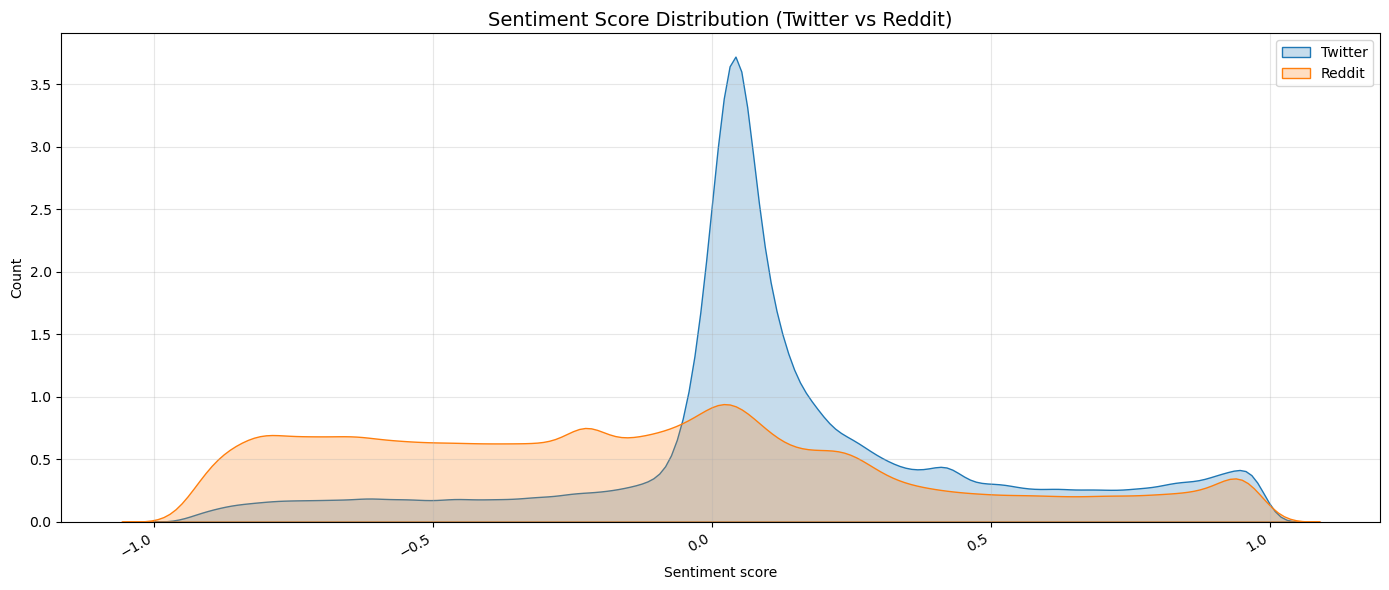

In [44]:
def plot_sentiment_distributions(df_tweets: pl.DataFrame, df_reddit: pl.DataFrame):
    """Basic plots for raw tweets & reddit sentiment."""
    tw_pd = prepare(df_tweets).to_pandas()
    rd_pd = prepare(df_reddit).to_pandas()
    plt.figure(figsize=(14, 6))
    sns.kdeplot(tw_pd["score"], fill=True, label="Twitter")
    sns.kdeplot(rd_pd["score"], fill=True, label="Reddit")
    
    apply_common_style(
        "Sentiment Score Distribution (Twitter vs Reddit)",
        xlabel="Sentiment score",
        ylabel="Count",
    )
    
plot_sentiment_distributions(df_tweets, df_reddit)

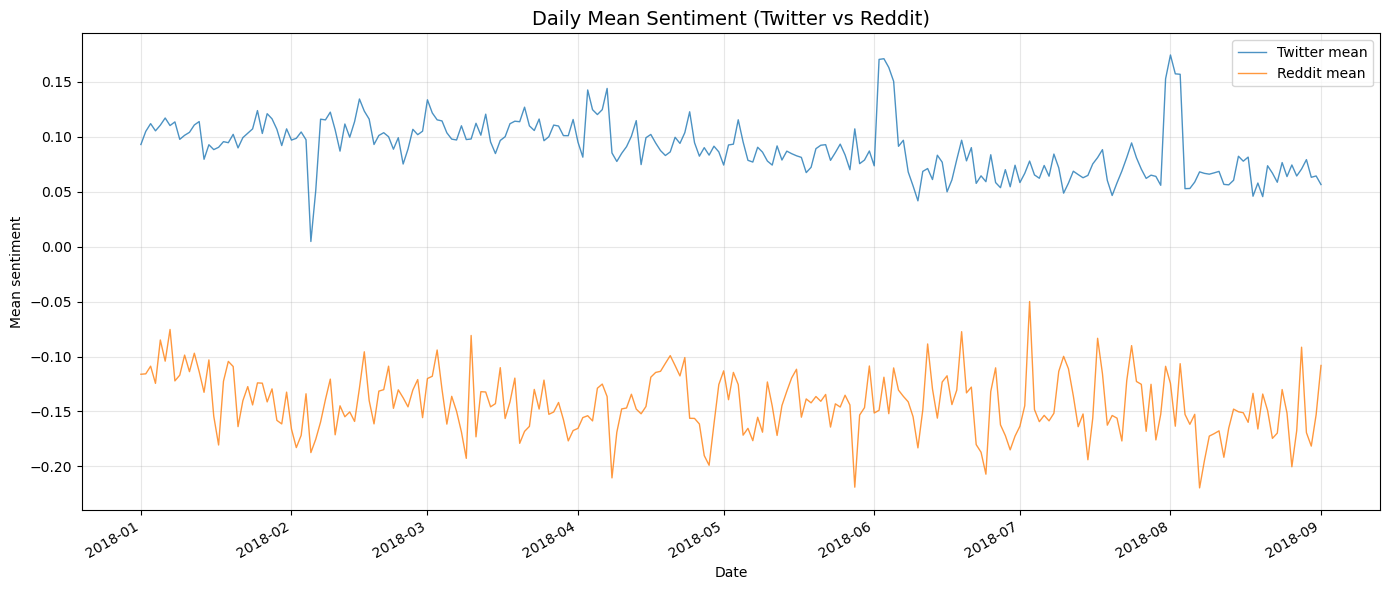

In [51]:
def plot_daily_means(df_tweets: pl.DataFrame, df_reddit: pl.DataFrame):
    tw_pd = prepare(df_tweets).group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date").to_pandas()
    rd_pd = prepare(df_reddit).group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(tw_pd["date"], tw_pd["mean_score"], linewidth=1, alpha=0.8, label="Twitter mean")
    plt.plot(rd_pd["date"], rd_pd["mean_score"], linewidth=1, alpha=0.8, label="Reddit mean")

    apply_common_style(
        "Daily Mean Sentiment (Twitter vs Reddit)",
        xlabel="Date",
        ylabel="Mean sentiment",
    )
plot_daily_means(df_tweets, df_reddit)

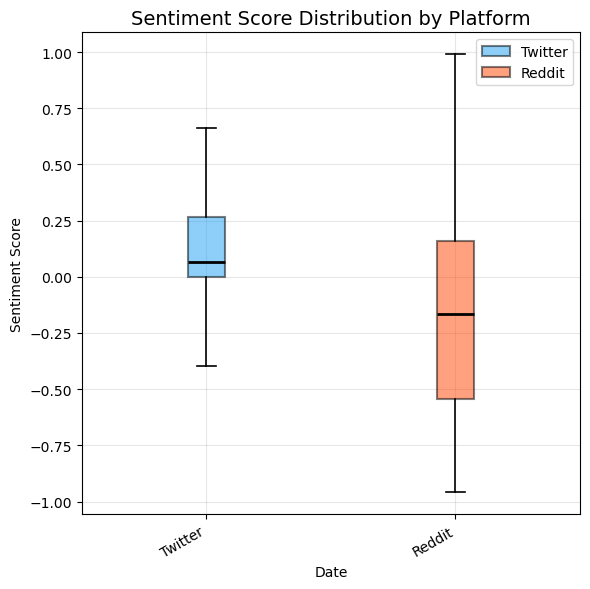

In [66]:
def plot_boxplots(df_tweets, df_reddit):
    tw = prepare(df_tweets).to_pandas()["score"]
    rd = prepare(df_reddit).to_pandas()["score"]

    data = [tw, rd]

    plt.figure(figsize=(6, 6))

    # Create boxplot
    bp = plt.boxplot(
        data,
        tick_labels=["Twitter", "Reddit"],
        patch_artist=True,
        showfliers=False,     # Hide extreme outliers for clarity
        boxprops=dict(linewidth=1.5),
        medianprops=dict(color="black", linewidth=2),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
        label=["Twitter", "Reddit"]
    )

    # Color the boxes
    colors = ["#1DA1F2", "#FF4500"]  # Twitter blue, Reddit orange
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

    apply_common_style(
        "Sentiment Score Distribution by Platform",
        xlabel="Date",
        ylabel="Sentiment Score",
    )
plot_boxplots(df_tweets, df_reddit)

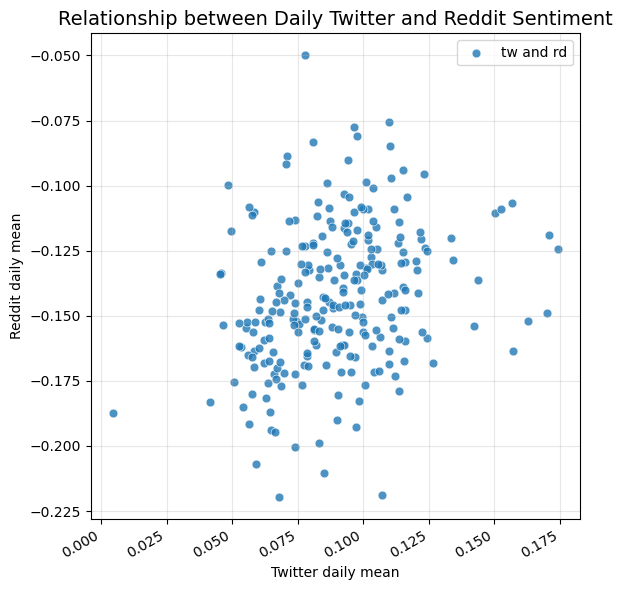

In [67]:
def plot_scatter(df_tweets, df_reddit):
    tw_pd = prepare(df_tweets).group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    rd_pd = prepare(df_reddit).group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    
    # Merge dates 
    merged = tw_pd.merge(rd_pd, on="date", suffixes=("_twitter", "_reddit"))

    # Scatter plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=merged, x="mean_twitter", y="mean_reddit", s=40, alpha=0.8,label="tw and rd")
    apply_common_style(
        "Relationship between Daily Twitter and Reddit Sentiment",
        xlabel="Twitter daily mean",
        ylabel="Reddit daily mean",
    )

plot_scatter(df_tweets, df_reddit)


#### Conclusion from EDA

Based on the EDA, we can draw the following conclusions:
- **Overall sentiment levels are very different between platforms**
    -  Twitter tends to lean **positive** on average, with **mean sentiment of +0.12**
    -  Reddit tends to lean **negative** on average, with **mean sentiment of -0.14**
    -  The **difference** is around **0.26**, visible in KDE and boxplots, Twitter’s distribution is skewed toward positive values, while Reddit’s is more spread out and shifted to the negative side.
- **Sentiment variability is higher on Reddit**
    - Twitter: 0.374
    - Reddit: 0.488
    - Reddit exhibits **more emotional variability**.
    - Indicate that Reddit are **more polarized and expressive**, while Twitter is more **concentrated near neutral or mildly positive**.
- **Daily sentiment trends are stable yet distinct between platforms**
    - Twitter shows a stable positive trend with **small fluctuations**.
    - Reddit consistently trends negative with **greater volatility**.
    - There is **no major sentiment shift on either platform**.
    - Both behave independently with their own typical emotional “baseline”.
- **Relationship between platforms is weak but positive**
    - The **daily correlation ≈ 0.27**.
    - **Weak positive relationship**: when Twitter sentiment rises, Reddit sentiment tends to rise slightly as well.
    - However, the large scatter in the points shows that **the platforms do not move together tightly**.
    - Both platforms respond somewhat to shared news cycles or real-world events,
    - But their userbases express emotions **quite differently**, so daily sentiment movements remain largely independent.
- **Distribution shape differences reflect community culture**
    - **Twitter** is dominated by neutral or slightly positive short posts → tighter distribution around 0–0.2.
    - **Reddit** content is longer, more opinionated, and often critical → broader distribution and negative central tendency.

Therefore in short: 
- **Twitter**
- More positive overall
- Less variable
- Sentiment tightly clustered around neutral-positive
- Stable day-to-day patterns

**Reddit**

- More negative overall
- More variable and expressive
- Broader distribution with stronger negative skew
- Higher day-to-day fluctuation
- **Cross-platform relationship**

- Weak positive correlation (~0.27)
- Some shared patterns, but major differences in tone and emotional expression

## Analysis Frequency

For the window of the data, we choose to have the frequency to be **Daily**, and let each window be indexed by $t$. For each window $t$:
- Aggregate sentiment disagreement using sentiment score or label with timestamp in window $t$
- Compute price instability for the next window $t+1$. 

## Sentiment Disagreement

Let $s_{i, t}$ be the sentiment score of the text $i$ in the window $t$. Where $i=1...N_t$, and $N_t$ is the total number of text in the window $t$. We choose two sentiment features:
- $D^{\text{MAD}}_t$: Median Absolute Deviation (MAD), this is the continuous score dispersion based on the median. Defined as:
$$D^{\text{MAD}}_t = \text{median}_i \Big(|s_{i, t}-\text{median}_i (s_{i, t})|\Big)$$
- $D^{\Delta \mu}_t$: Mean Gap fot the cross-platform disagreement between Twitter and Reddit. First compute the mean sentiment per platform $\mu_{t}^{tw}$ and $\mu_{t}^{rd}$. Then the mean gap between the platform is defined as:
$$D^{\Delta \mu}_t= \bigg|\mu_{t}^{tw} - \mu_{t}^{rd}\bigg|$$

In [ ]:
def daily_stats(df: pl.DataFrame, prefix: str) -> pl.DataFrame:
    """
    Return df with needed stats for Twitter and Reddit
     - For example: ['date', 'reddit_mean', 'reddit_median', 'reddit_mad', 'reddit_n']
     - MAD is defined as median(|x - median(x)|
    """
    df2 = df.with_columns(pl.col("score").median().over("date").alias("med"))
    df2 = df2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

    return (
        df2.group_by("date")
           .agg([
               pl.col("score").mean().alias(f"{prefix}mean"),
               pl.col("score").median().alias(f"{prefix}median"),
               pl.col("abs_dev").median().alias(f"{prefix}mad"),
               pl.len().alias(f"{prefix}n"),
           ])
           .sort("date")
    )

def sentiment_disagreement_daily(
    reddit_df: pl.DataFrame,
    tweets_df: pl.DataFrame,
    ts_col: str = "timestamp",
    score_col: str = "sentiment_score"
) -> pl.DataFrame:
    """
    Returns per-day sentiment features:
      - D_mad: MAD across ALL posts (Twitter + Reddit)
      - D_gap: abs(mean_twitter - mean_reddit)
    Also includes per-platform means/counts/MADs as useful parameters.
    """

    rd = prepare(reddit_df)
    tw = prepare(tweets_df)

    rd_stats = daily_stats(rd, "reddit_")
    tw_stats = daily_stats(tw, "twitter_")
    print(rd_stats.columns)
    # Twitter-Reddit mean gap (absolute)
    platform = (
        tw_stats.join(rd_stats, on="date", how="full")
                .with_columns((pl.col("twitter_mean") - pl.col("reddit_mean")).abs().alias("D_gap"))
                .sort("date")
    )

    # Combined MAD across ALL posts (Twitter + Reddit)
    all_scores = pl.concat([tw, rd], how="vertical")
    all2 = all_scores.with_columns(pl.col("score").median().over("date").alias("med"))
    all2 = all2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

    all_daily = (
        all2.group_by("date")
            .agg([
                pl.col("abs_dev").median().alias("D_mad"),
                pl.col("score").mean().alias("all_mean"),
                pl.len().alias("all_n"),
            ])
            .sort("date")
    )

    return platform.join(all_daily, on="date", how="left").sort("date")

Function that plot daily sentiment disagreement with $D^{\text{MAD}}_t$ and $D^{\Delta\mu}_t$

In [ ]:
def plot_daily_sentiment_disagreement(sent_daily: pl.DataFrame):
    """Plots D_mad and D_gap over time with unified style."""
    df = sent_daily.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["D_mad"], linewidth=1, alpha=0.8, label="D_mad")
    plt.plot(df["date"], df["D_gap"], linewidth=1, alpha=0.8, label="D_gap")

    apply_common_style(
        "Daily Sentiment Disagreement (D_mad & D_gap)",
        xlabel="Date",
        ylabel="Value",
    )

In [ ]:
sent_train = sentiment_disagreement_daily(df_tweets, df_reddit)
plot_daily_sentiment_disagreement(sent_train)   
print(sent_train.columns)

### Load BTC data and plot raw data
We can load the btc that already contain part 1 to 4 and plot the raw btc close price with 1m interval

In [ ]:
def plot_raw_btc_1m(df_btc: pl.DataFrame, ts_col="timestamp", close_col="close", vol_col="volume"):
    """Basic plots for raw 1m BTC: close price + volume."""
    btc = (
        df_btc.select([ts_col, close_col, vol_col])
              .drop_nulls(close_col)
              .sort(ts_col)
    )

    btc_pd = btc.to_pandas()

    # Price
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[close_col], linewidth=1, alpha=0.8)
    _apply_common_style("BTC 1-Minute Close Price", xlabel="Date", ylabel="Price (USD)")
    plt.show()

    # Volume
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[vol_col], linewidth=1, alpha=0.8)
    _apply_common_style("BTC 1-Minute Volume", xlabel="Date", ylabel="Volume")
    plt.show()

In [ ]:
df_btc = data.load_btc("../data/btc_training.csv")
plot_raw_btc_1m(df_btc)

### Compute Price Instability

Let $r_t$ be the close-to-close log return, the measure of relative price change from one window to the next window using logarithmic scale. Defined using close price $C$: 
$$r_t=\log\left(\frac{C_t}{C_{t-1}}\right)$$ 

Using $r_t$ we can define the realized volatility: 
$$RV_t=\sqrt{\sum_{i\in t}r_i^2}$$


In [ ]:
def btc_daily_instability_from_1m(
    btc_df: pl.DataFrame,
    ts_col: str = "timestamp",
    open_col: str = "open",
    high_col: str = "high",
    low_col: str = "low",
    close_col: str = "close",
    vol_col: str = "volume",
    require_full_day: bool = True,
    full_day_bars: int = 1440,   # 24*60 for 1m crypto
) -> pl.DataFrame:
    """
    Computes daily price instability from 1-minute OHLCV:
      - rv: realized volatility = sqrt(sum intraday log-return^2)
      - parkinson: range-based daily estimator using daily high/low
      - absret_daily: abs(close-to-close daily log return)

    If require_full_day=True, keeps only days with exactly 1440 bars.
    """

    btc = (
        btc_df.select([ts_col, open_col, high_col, low_col, close_col, vol_col])
              .drop_nulls([close_col])
              .with_columns([
                  pl.col(ts_col).dt.date().alias("date"),
                  pl.col(open_col).cast(pl.Float64).alias("open"),
                  pl.col(high_col).cast(pl.Float64).alias("high"),
                  pl.col(low_col).cast(pl.Float64).alias("low"),
                  pl.col(close_col).cast(pl.Float64).alias("close"),
                  pl.col(vol_col).cast(pl.Float64).alias("volume"),
              ])
              .sort(ts_col)
    )

    # Intraday log returns within each day (order matters)
    btc = btc.with_columns(pl.col("close").log().alias("log_close"))
    btc = btc.with_columns(
        (pl.col("log_close") - pl.col("log_close").shift(1).over("date")).alias("logret_intra")
    )
    btc = btc.with_columns(pl.col("logret_intra").fill_null(0.0).pow(2).alias("logret2"))
    LN2 = float(math.log(2.0))
    SQRT_365 = float(math.sqrt(365.0))
    daily = (
        btc.group_by("date")
           .agg([
               pl.len().alias("n_bars"),
               pl.col("open").sort_by(ts_col).first().alias("open_d"),
               pl.col("high").max().alias("high_d"),
               pl.col("low").min().alias("low_d"),
               pl.col("close").sort_by(ts_col).last().alias("close_d"),
               pl.col("volume").sum().alias("volume_d"),
               pl.col("logret2").sum().alias("rv_var"),
               pl.col("logret_intra").is_not_null().sum().alias("n_returns"),
           ])
           .sort("date")
           .with_columns([
               pl.col("rv_var").sqrt().alias("rv"),
               (pl.col("rv_var").sqrt() * SQRT_365).alias("rv_ann"),  # optional annualized
               ((pl.col("high_d") / pl.col("low_d")).log().pow(2) / (4.0 * LN2)).sqrt().alias("parkinson"),
           ])
    )

    # daily close-to-close log return + abs return
    daily = daily.with_columns([
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).alias("logret_daily"),
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).abs().alias("absret_daily"),
    ])

    if require_full_day:
        daily = daily.filter(pl.col("n_bars") == full_day_bars)

    return daily

In [ ]:
def plot_btc_daily_instability(btc_daily: pl.DataFrame):
    """Plots daily rv, parkinson, and absret_daily with unified style."""
    df = btc_daily.sort("date").to_pandas()

    # Realized volatility
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["rv"], linewidth=1, alpha=0.8)
    _apply_common_style("Daily Realized Volatility (rv)", xlabel="Date", ylabel="rv")
    plt.show()

    # Parkinson
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["parkinson"], linewidth=1, alpha=0.8)
    _apply_common_style("Daily Parkinson Volatility", xlabel="Date", ylabel="Parkinson")
    plt.show()

    # Absolute daily return
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["absret_daily"], linewidth=1, alpha=0.8)
    _apply_common_style(
        "Daily Absolute Close-to-Close Log Return",
        xlabel="Date",
        ylabel="|logret|",
    )
    plt.show()


In [ ]:
btc_train  = btc_daily_instability_from_1m(df_btc, require_full_day=True)
print(btc_train.columns)
plot_btc_daily_instability(btc_train)

### Combine Sentiment Disagreement with Price Instability to build a model
We try to predict the future using only inforation that would have been know at the time, therefore we shift the values by one day to create lagged values:
- Lagged Daily MAD
- Lagged Daily Mean Gap
- Lagged Daily RV

This represent the question:
> Given everything I knew up to the end of day $t-1$, can I predict volatility on day $t$

The training target we define as the **Realized Volatility**, this means the learning objective is: 
> Given yesterday's sentiment and volatility, predict today's realized volatility

In [ ]:
def build_daily_model_df(
    btc_daily: pl.DataFrame,
    sent_daily: pl.DataFrame,
    target_col: str = "rv",   # choose "rv" (realized vol) or "parkinson" etc.
) -> pl.DataFrame:
    """
    Produces modeling table where day t target uses disagreement from day t-1:
      y_t = target(t)
      X_t includes D_mad(t-1), D_gap(t-1), rv(t-1) etc.
    """
    df = (
        btc_daily.join(sent_daily, on="date", how="left")
                 .sort("date")
                 .with_columns([
                     pl.col("D_mad").shift(1).alias("D_mad_lag1"),
                     pl.col("D_gap").shift(1).alias("D_gap_lag1"),
                     pl.col(target_col).shift(1).alias(f"{target_col}_lag1"),
                 ])
                 .with_columns(pl.col(target_col).alias("y"))
                 .drop_nulls(subset=["y", "D_mad_lag1", "D_gap_lag1", f"{target_col}_lag1"])
    )
    return df

In [ ]:
def plot_model_target_timeseries(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Plots y_t and target_lag1 over time.
    base_target is the original target_col used in build_daily_model_df
    (e.g. "rv" or "parkinson").
    """
    df = model_train.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["y"], linewidth=1, alpha=0.8, label="y (target today)")
    lag_col = f"{base_target}_lag1"
    if lag_col in df.columns:
        plt.plot(df["date"], df[lag_col], linewidth=1, alpha=0.8, label=f"{lag_col}")

    _apply_common_style(
        title=f"Daily Target and Lagged Target ({base_target})",
        xlabel="Date",
        ylabel=base_target,
    )
    plt.legend()
    plt.show()

def plot_model_feature_scatter(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Scatter plots of y vs each predictor:
      - D_mad_lag1
      - D_gap_lag1
      - base_target_lag1 (e.g. rv_lag1)
    """
    df = model_train.to_pandas()

    features = ["D_mad_lag1", "D_gap_lag1", f"{base_target}_lag1"]
    titles = {
        "D_mad_lag1": "y vs D_mad_lag1 (disagreement MAD, t-1)",
        "D_gap_lag1": "y vs D_gap_lag1 (mean gap, t-1)",
        f"{base_target}_lag1": f"y vs {base_target}_lag1 (target lag-1)",
    }

    for feat in features:
        if feat not in df.columns:
            continue

        plt.figure(figsize=(14, 6))
        plt.scatter(df[feat], df["y"], s=10, alpha=0.6)
        _apply_common_style(
            title=titles.get(feat, f"y vs {feat}"),
            xlabel=feat,
            ylabel="y (target)",
        )
        plt.tight_layout()
        plt.show()

def plot_model_correlations(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Correlation matrix between y and main predictors,
    visualized as a heatmap.
    """
    cols = ["y", "D_mad_lag1", "D_gap_lag1", f"{base_target}_lag1"]
    # keep only existing columns
    cols = [c for c in cols if c in model_train.columns]

    df = model_train.select(cols).to_pandas()
    corr = df.corr()

    plt.figure(figsize=(6, 5))
    im = plt.imshow(corr.values, interpolation="nearest", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)

    plt.title("Correlation Matrix (Target & Predictors)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
model_train = build_daily_model_df(btc_train, sent_train, target_col="rv")
plot_model_target_timeseries(model_train, base_target="rv")

In [ ]:
plot_model_feature_scatter(model_train, base_target="rv")

In [ ]:
plot_model_correlations(model_train, base_target="rv")

In [ ]:
def part_bounds(part: int):
    year_start = datetime(2018, 1, 1)
    year_end   = datetime(2019, 1, 1)
    step = (year_end - year_start) / 6
    slice_start = year_start + step * (part - 1)
    slice_end   = year_start + step * part
    return slice_start, slice_end

def keep_full_days_inside(df_daily: pl.DataFrame, slice_start, slice_end) -> pl.DataFrame:
    """
    Keep ONLY days where the entire [00:00, 24:00) interval is inside [slice_start, slice_end).
    This avoids "split day" leakage when your part boundaries cut through a day.
    """
    return (
        df_daily
        .with_columns([
            pl.col("date").cast(pl.Datetime).alias("day_start"),
            (pl.col("date").cast(pl.Datetime) + pl.duration(days=1)).alias("day_end"),
        ])
        .filter((pl.col("day_start") >= slice_start) & (pl.col("day_end") <= slice_end))
        .drop(["day_start", "day_end"])
        .sort("date")
    )


In [ ]:
# Combine raw data so lag(1) can cross the train->val boundary correctly
tweets_1to4 = data.load_data_sentiment("../data/tweets_training.csv")
tweets_5 = data.load_data_sentiment("../data/sentiment/tweets_5_sent.csv")
reddit_1to4 = data.load_data_sentiment("../data/reddit_training.csv")
reddit_5 = data.load_data_sentiment("../data/sentiment/reddit_5_sent.csv")
btc_1to4 = data.load_btc("../data/btc_training.csv")
btc_5 = data.load_btc("../data/btc_5.csv")


reddit_1to5 = pl.concat([reddit_1to4, reddit_5], how="vertical").sort("timestamp")
tweets_1to5 = pl.concat([tweets_1to4, tweets_5], how="vertical").sort("timestamp")
btc_1to5    = pl.concat([btc_1to4, btc_5], how="vertical").sort("timestamp")

# Daily sentiment features (D_mad, D_gap)
sent_1to5 = sentiment_disagreement_daily(reddit_1to5, tweets_1to5)

# Daily BTC instability from 1m bars (rv etc.)
btc_daily_1to5 = btc_daily_instability_from_1m(btc_1to5, require_full_day=True)

# Join + lag features; y = today's rv
model_1to5 = build_daily_model_df(btc_daily_1to5, sent_1to5, target_col="rv")

model_1to5.select(["date","y","D_mad_lag1","D_gap_lag1","rv_lag1"]).head()


In [ ]:
train_start, _        = part_bounds(1)
_, train_end          = part_bounds(4)
val_start, val_end    = part_bounds(5)

train_df = keep_full_days_inside(model_1to5, train_start, train_end)
val_df   = keep_full_days_inside(model_1to5, val_start, val_end)

print("train days:", train_df.height)
print("val days:",   val_df.height)


In [ ]:
# def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
# def mae(a, b):  return float(np.mean(np.abs(a - b)))

# def fit_predict(train_df: pl.DataFrame, val_df: pl.DataFrame, x_cols: list[str]):
#     eps = 1e-12
#     y_tr = np.log(train_df["y"].to_numpy() + eps)
#     y_va = np.log(val_df["y"].to_numpy() + eps)

#     if len(x_cols) == 0:
#         X_tr = np.ones((len(y_tr), 1))
#         X_va = np.ones((len(y_va), 1))
#     else:
#         X_tr = train_df.select(x_cols).to_numpy()
#         X_va = val_df.select(x_cols).to_numpy()
#         X_tr = sm.add_constant(X_tr, has_constant="add")
#         X_va = sm.add_constant(X_va, has_constant="add")

#     # HAC is good practice even here (vol series autocorrelates)
#     res = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": 7})
#     pred = res.predict(X_va)

#     return res, y_va, pred

# # 1) Baseline
# res0, y_va, pred0 = fit_predict(train_df, val_df, [])
# print("BASELINE (const only)  RMSE:", rmse(y_va, pred0), " MAE:", mae(y_va, pred0))

# # 2) Add MAD disagreement
# res_mad, y_va, pred_mad = fit_predict(train_df, val_df, ["D_mad_lag1"])
# print("+ D_mad_lag1          RMSE:", rmse(y_va, pred_mad), " MAE:", mae(y_va, pred_mad))
# print("beta(D_mad_lag1) =", res_mad.params[1], "  p(two-sided) =", res_mad.pvalues[1])

# # 3) Add mean-gap disagreement
# res_gap, y_va, pred_gap = fit_predict(train_df, val_df, ["D_gap_lag1"])
# print("+ D_gap_lag1          RMSE:", rmse(y_va, pred_gap), " MAE:", mae(y_va, pred_gap))
# print("beta(D_gap_lag1) =", res_gap.params[1], "  p(two-sided) =", res_gap.pvalues[1])


In [ ]:
# res_ar, y_va, pred_ar = fit_predict(train_df, val_df, ["rv_lag1"])
# print("AR(1) baseline (rv_lag1)   RMSE:", rmse(y_va, pred_ar), " MAE:", mae(y_va, pred_ar))

# res_ar_mad, y_va, pred_ar_mad = fit_predict(train_df, val_df, ["rv_lag1", "D_mad_lag1"])
# print("AR(1) + D_mad_lag1         RMSE:", rmse(y_va, pred_ar_mad), " MAE:", mae(y_va, pred_ar_mad))


In [ ]:
EPS = 1e-12

def design_matrix(df_pl, x_cols):
    """Return (X, names) with intercept."""
    n = df_pl.height
    if len(x_cols) == 0:
        return np.ones((n, 1)), ["const"]
    X = df_pl.select(x_cols).to_numpy()
    X = sm.add_constant(X, has_constant="add")
    return X, ["const"] + x_cols

def fit_predict(train_df, val_df, x_cols, y_col="y", log_y=True, hac_lags=7):
    """Fit OLS on train, predict val. Returns result + arrays in log and raw scale."""
    y_tr_raw = train_df[y_col].to_numpy()
    y_va_raw = val_df[y_col].to_numpy()

    if log_y:
        y_tr = np.log(y_tr_raw + EPS)
        y_va = np.log(y_va_raw + EPS)
    else:
        y_tr = y_tr_raw
        y_va = y_va_raw

    X_tr, names = design_matrix(train_df, x_cols)
    X_va, _ = design_matrix(val_df, x_cols)

    res = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    pred_va = res.predict(X_va)

    if log_y:
        pred_va_raw = np.exp(pred_va) - EPS
    else:
        pred_va_raw = pred_va

    return {
        "res": res,
        "names": names,
        "x_cols": x_cols,
        "y_va": y_va,
        "pred_va": pred_va,
        "y_va_raw": y_va_raw,
        "pred_va_raw": pred_va_raw,
    }

def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat) ** 2)))
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))

# --- Define your baseline + augmented specs ---
MODELS = {
    "Baseline_const": [],
    "D_only_MAD": ["D_mad_lag1"],
    "D_only_GAP": ["D_gap_lag1"],
    "D_only_BOTH": ["D_mad_lag1", "D_gap_lag1"],

    # better baseline for volatility
    "Baseline_AR1": ["rv_lag1"],
    "AR1_plus_MAD": ["rv_lag1", "D_mad_lag1"],
    "AR1_plus_GAP": ["rv_lag1", "D_gap_lag1"],
    "AR1_plus_BOTH": ["rv_lag1", "D_mad_lag1", "D_gap_lag1"],
}

# --- Fit all models (train) and evaluate on validation ---
results = {}
metrics = []

for name, x_cols in MODELS.items():
    out = fit_predict(train_df, val_df, x_cols, y_col="y", log_y=True, hac_lags=7)
    results[name] = out

    metrics.append({
        "model": name,
        "rmse_log": rmse(out["y_va"], out["pred_va"]),
        "mae_log": mae(out["y_va"], out["pred_va"]),
        "rmse_raw": rmse(out["y_va_raw"], out["pred_va_raw"]),
        "mae_raw": mae(out["y_va_raw"], out["pred_va_raw"]),
    })

# Pick best by RMSE on raw scale (change to rmse_log if you prefer)
best_model = min(metrics, key=lambda d: d["rmse_raw"])["model"]
print("Best model on validation by RMSE(raw):", best_model)
best_model = min(metrics, key=lambda d: d["rmse_log"])["model"]
print("Best model on validation by rmse_log:", best_model)
best_model = min(metrics, key=lambda d: d["mae_raw"])["model"]
print("Best model on validation by mae_raw:", best_model)
best_model = min(metrics, key=lambda d: d["mae_log"])["model"]
print("Best model on validation by mae_log:", best_model)


In [ ]:
def extract_term(res, names, term, alpha=0.05):
    idx = names.index(term)
    beta = float(res.params[idx])
    se = float(res.bse[idx])
    t = float(res.tvalues[idx])
    p2 = float(res.pvalues[idx])  # two-sided
    ci = res.conf_int(alpha=alpha)[idx]
    return {
        "term": term, "beta": beta, "se": se, "t": t, "p2": p2,
        "ci_low": float(ci[0]), "ci_high": float(ci[1]),
    }

def plot_term_cis(results, term, alpha=0.05, title=None):
    rows = []
    for model_name, out in results.items():
        if term in out["names"]:
            rows.append((model_name, extract_term(out["res"], out["names"], term, alpha)))

    if not rows:
        print(f"No models contained term: {term}")
        return

    labels = [r[0] for r in rows]
    betas  = np.array([r[1]["beta"] for r in rows])
    lows   = np.array([r[1]["ci_low"] for r in rows])
    highs  = np.array([r[1]["ci_high"] for r in rows])
    errs_low  = betas - lows
    errs_high = highs - betas

    x = np.arange(len(labels))

    plt.figure(figsize=(10, 4))
    plt.errorbar(x, betas, yerr=[errs_low, errs_high], fmt="o")
    plt.axhline(0.0)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Coefficient (log-vol scale)")
    plt.title(title or f"{term}: coefficient ± {(1-alpha)*100:.0f}% CI (HAC)")
    plt.tight_layout()
    plt.show()

plot_term_cis(results, "D_mad_lag1", alpha=0.05, title="Effect of MAD disagreement (lag 1)")
plot_term_cis(results, "D_gap_lag1", alpha=0.05, title="Effect of Twitter–Reddit mean gap (lag 1)")


In [ ]:
def plot_actual_vs_pred(val_df, out_a, label_a, out_b, label_b, use_raw=True):
    dates = val_df["date"].to_list()

    if use_raw:
        y = out_a["y_va_raw"]
        yhat_a = out_a["pred_va_raw"]
        yhat_b = out_b["pred_va_raw"]
        ylabel = "Volatility (raw, e.g. RV)"
    else:
        y = out_a["y_va"]
        yhat_a = out_a["pred_va"]
        yhat_b = out_b["pred_va"]
        ylabel = "log(Volatility)"

    plt.figure(figsize=(10, 4))
    plt.plot(dates, y, label="Actual")
    plt.plot(dates, yhat_a, label=label_a)
    plt.plot(dates, yhat_b, label=label_b)
    plt.legend()
    plt.ylabel(ylabel)
    plt.title("Validation: actual vs predicted")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

baseline_name = "Baseline_AR1"  # better baseline for vol
plot_actual_vs_pred(val_df, results[baseline_name], baseline_name, results[best_model], best_model, use_raw=True)


In [ ]:
def coef_test(res, names, term, alpha=0.05, alternative="greater"):
    """
    alternative:
      - "two-sided": H1 beta != 0
      - "greater"  : H1 beta > 0
      - "less"     : H1 beta < 0
    """
    idx = names.index(term)
    beta = float(res.params[idx])
    t = float(res.tvalues[idx])
    p2 = float(res.pvalues[idx])  # two-sided

    if alternative == "two-sided":
        p = p2
    elif alternative == "greater":
        p = (p2 / 2.0) if beta > 0 else (1.0 - p2 / 2.0)
        reject = p < alpha
    elif alternative == "less":
        p = (p2 / 2.0) if beta < 0 else (1.0 - p2 / 2.0)
        reject = p < alpha
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    return {"term": term, "beta": beta, "t": t, "p": float(p), "alpha": alpha, "reject_H0": bool(reject)}

# Example: test D_mad_lag1 in AR1_plus_MAD
chosen = results["AR1_plus_MAD"]
test_out = coef_test(chosen["res"], chosen["names"], "D_mad_lag1", alpha=0.05, alternative="greater")
print(test_out)


In [ ]:
def plot_null_test_normal(t_stat, alpha=0.05, alternative="greater", title="Hypothesis test (normal approx)"):
    x = np.linspace(-4, 4, 1000)
    pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)

    # critical values
    if alternative == "two-sided":
        crit = 1.959963984540054  # approx for alpha=0.05
        reject_left = x <= -crit
        reject_right = x >= crit
    elif alternative == "greater":
        crit = 1.6448536269514722
        reject_left = np.zeros_like(x, dtype=bool)
        reject_right = x >= crit
    elif alternative == "less":
        crit = 1.6448536269514722
        reject_left = x <= -crit
        reject_right = np.zeros_like(x, dtype=bool)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf)
    plt.fill_between(x, 0, pdf, where=reject_left)
    plt.fill_between(x, 0, pdf, where=reject_right)
    plt.axvline(t_stat)
    plt.axvline(crit if alternative != "less" else -crit, linestyle="--")
    if alternative == "two-sided":
        plt.axvline(-crit, linestyle="--")

    plt.title(title + f" | alpha={alpha}, alt={alternative}")
    plt.xlabel("Test statistic (t or z)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

# Use the t-stat from the same coefficient test you ran
plot_null_test_normal(test_out["t"], alpha=0.05, alternative="greater",
                      title="H0: beta=0 vs H1: beta>0 for D_mad_lag1 (AR1_plus_MAD)")


In [ ]:
def plot_metric_bar(metrics, metric_key, title):
    labels = [m["model"] for m in metrics]
    values = [m[metric_key] for m in metrics]
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 4))
    plt.bar(x, values)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel(metric_key)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Sort by performance to make it readable
metrics_sorted = sorted(metrics, key=lambda d: d["rmse_raw"])
plot_metric_bar(metrics_sorted, "rmse_raw", "Validation RMSE (raw scale): baseline vs augmented")
plot_metric_bar(metrics_sorted, "mae_raw",  "Validation MAE (raw scale): baseline vs augmented")

# (Optional) also in log scale (often smoother)
metrics_sorted_log = sorted(metrics, key=lambda d: d["rmse_log"])
plot_metric_bar(metrics_sorted_log, "rmse_log", "Validation RMSE (log scale)")
plot_metric_bar(metrics_sorted_log, "mae_log",  "Validation MAE (log scale)")
